# Factorization-Based Data Modeling
## Practical Work 2
by Luka Jakovljevic & Walid Gara

# Task:
## 1 Matrix Factorization with Stochastic Gradient Descent
In this section, you will implement the stochastic gradient descent algorithm for large-scale matrix factorization. The problem that we aim to solve is given as follows:

$(W^*,H^*) = \arg \min_{W,H} \frac{1}{2} \parallel M \odot (X-WH) \parallel^{2}_{F}$  
Where $ X \in \mathbb{R}^{I \times J} $  is the data matrix and $ W \in \mathbb{R}^{I \times K} $ and $ H \in \mathbb{R}^{K \times J} $ are unknown factor matrices

Here
$  \parallel A \parallel_{F}$ denotes the Frobenius norm of a matrix A and $  \odot $ denotes element-wise multiplication.

## 2 Movie Recommendation
We will work on the MovieLens 1 Million dataset. This dataset contains ~1 million ratings applied to I = 3883 movies by J = 6040 users, resulting in a sparse data matrix X with 4,3% non-zero entries. Our aim will be to decompose this matrix into W and H by only using its observed entries. Once we obtain estimates for W and H, we can then use them for predicting the unobserved entries of X, which will enable us to make recommendations.


# Exercises
### 1. Complete the stochastic gradient algorithm.

### 2. At the end of each iteration, compute the roor-mean-squared-error, that is given as follows:
 $ RMSE =  \sqrt{\frac{\parallel M \odot (X-WH) \parallel^{2}_{F}}{N}}$  
 Where $N$ is the number of ovserved entries in $X$
 
### 3. Play with the algorithm parameters, i.e. the step-size, the batch-size, initialization, and the rank of the factorization. What do you observe? How do the step-size and the batch-size interact?

### 4. After estimating W and H, use them to recommend a movie for a given user.



# Solution:

## SGD and RMSE

In [214]:
import scipy.io as scio
import numpy as np
Xsp=scio.loadmat("ml_1m.mat")["X"]
Xsp=Xsp.tocoo(copy=False)

In [65]:
#visualize the non-zero elements in Xsp
np.nonzero(Xsp)

(array([   0,   47,  148, ..., 3666, 3682, 3749]),
 array([   0,    0,    0, ..., 6039, 6039, 6039]))

In [66]:
#we can obtain the mask matrix from Xsp
M = Xsp == 1

In [128]:
I,J = Xsp.shape
N=len(Xsp.data) #or N = Xsp.getnnz() for number of non-zeros

print('Only '+str(100*N/(I*J))+' percent of the matrix is full!')

#create a list of elements that will be useful later
Xi = Xsp.row
Xj = Xsp.col
Xs = Xsp.data

Xlist = [Xi,Xj,Xs]

Only 4.264679797998748 percent of the matrix is full!


In [129]:
#initialize the factor matrices
from numpy.random import randn, random

K = 10 #set the rank

W = 1 * randn(I,K) 
H = 1 * randn(K,J)

In [130]:
#stochastic gradient descent


batchSize = 1000 #the number of elements that we will use at each iteration

eta = 0.02 #step-size
numIter = 100

rmse_sgd = np.zeros(numIter)

In [136]:
from numpy.linalg import inv, norm
import math
import scipy.sparse as sp

for t in range(numIter):
    
    #get a random batch from the data
    data_index = np.random.permutation(N)[:batchSize]
    #this vector will contain some random numbers between 1 and N. 
    #Its size should be batchSize. You can use the function randperm
    
    #for each element in the data batch, update the corresponding elements in W and H
    for i in range(batchSize):
       # for each element in the batch, find its corresponding 'i', 'j' and value by using the Xlist array
       cur_i = Xlist[0][data_index[i]]
       cur_j = Xlist[1][data_index[i]]
       cur_x = Xlist[2][data_index[i]]
       
       #compute the current xhat, for the current i and j
       cur_xhat = W[cur_i,:].dot(H[:,cur_j])
       
       #compute the gradients for the 'corresponding elements' of W and H 
       #not all the elements of W and H will be updated
       grad_w =  - (cur_x - cur_xhat)*(H[:,cur_j].T)
       grad_h =  - W[cur_i,:].T.dot(cur_x - cur_xhat)
       
       #take a gradient step
       W[cur_i,:] = W[cur_i,:] - eta * grad_w
       H[:,cur_j] = H[:,cur_j] - eta * grad_h
    
    #compute the root-mean-squared error
    A = Xsp-W.dot(H)
    frob = sp.csr_matrix(M).multiply(sp.csr_matrix(A)).todense()
    solution = math.sqrt((norm(frob,'fro')**2)/N)
    rmse_sgd[t] = solution
    print('Iteration '+str(t))

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

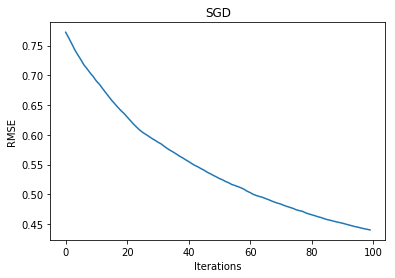

In [137]:
import matplotlib.pyplot as plt
# Plot results
plt.plot(range(0, numIter), rmse_sgd)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title('SGD')
plt.show()

# Playing with the algorithm parameters:

Just putting everything into a function to make it easier

In [211]:
def optimizer(number_of_iterations, _eta, batch_size, matrix_rank):

    W = 1 * randn(I,matrix_rank) 
    H = 1 * randn(matrix_rank,J)
    for t in range(number_of_iterations):

        #get a random batch from the data
        data_index = np.random.permutation(N)[:batch_size]
        #this vector will contain some random numbers between 1 and N. 
        #Its size should be batchSize. You can use the function randperm

        #for each element in the data batch, update the corresponding elements in W and H
        for i in range(batch_size):
           # for each element in the batch, find its corresponding 'i', 'j' and value by using the Xlist array
           cur_i = Xlist[0][data_index[i]]
           cur_j = Xlist[1][data_index[i]]
           cur_x = Xlist[2][data_index[i]]

           #compute the current xhat, for the current i and j
           cur_xhat = W[cur_i,:].dot(H[:,cur_j])

           #compute the gradients for the 'corresponding elements' of W and H 
           #not all the elements of W and H will be updated
           grad_w =  - (cur_x - cur_xhat)*(H[:,cur_j].T)
           grad_h =  - W[cur_i,:].T.dot(cur_x - cur_xhat)

           #take a gradient step
           W[cur_i,:] = W[cur_i,:] - eta * grad_w
           H[:,cur_j] = H[:,cur_j] - eta * grad_h

        #compute the root-mean-squared error
        A = Xsp-W.dot(H)
        frob = sp.csr_matrix(M).multiply(sp.csr_matrix(A)).todense()
        solution = math.sqrt((norm(frob,'fro')**2)/N)
        rmse_sgd[t] = solution
        print('Iteration '+str(t))
    
    # Plot results
    plt.plot(range(0, number_of_iterations), rmse_sgd)
    plt.xlabel("Iterations")
    plt.ylabel("RMSE")
    plt.title('SGD')
    plt.show()

### Increasing Rank:

Rank K = 30, step eta = 0.02, batch size = 1000

As can be seen bellow, by comparing the graphs, we can see that higher K will not necessarily produce better results, even though the higher K produces better aproximation of the X^. Also, execution time rises as K rises.

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

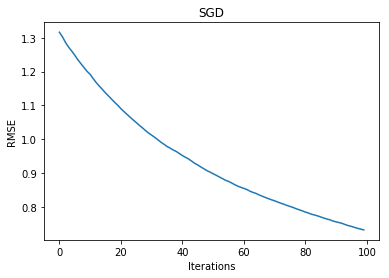

In [212]:
optimizer(number_of_iterations=100, matrix_rank=30, _eta=0.02, batch_size=1000)

### Decreasing step size:

Rank K = 10, step eta = 0.001, batch size = 1000

The result is similar as in the first example with the higher step size. 
By taking a smaller step size, algorithm converges slower.

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

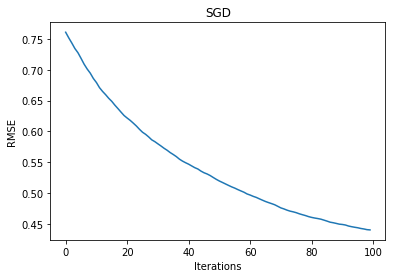

In [213]:
optimizer(number_of_iterations=100, matrix_rank=10, _eta=0.001, batch_size=1000)

### Decreasing batch size:

Rank K = 10, step eta = 0.02, batch size = 100

Here we see the small instabilty, because we are taking a bigger step on a smaller set of entries. 
The convergence is even slower and linear.

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

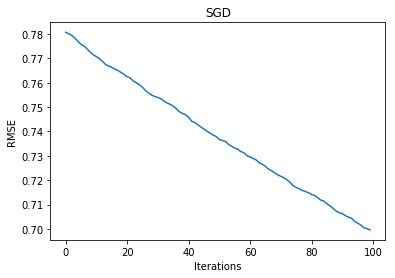

In [216]:
optimizer(number_of_iterations=100, matrix_rank=10, _eta=0.02, batch_size=100)

# Recommending a movie for a given user

In [210]:
#Make recommendations
user_index = 11
M_op = np.ones((I,J))- M
user_mask = M_op[:, user_index]
user_result = W.dot(H[:, user_index].reshape(-1, 1))
user_result[np.where(user_mask == 0)[0]] = 0
movie_index = np.argmax(user_result, axis=0)

print('Recommend movie '+str(movie_index[0]) + ' to user '+str(user_index))

Recommend movie 2762 to user 11
